In [15]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch

In [2]:
# --- 1. Load and Merge Data ---

# Load data
# train_transaction = pd.read_csv('../input/train_transaction.csv')
# train_identity = pd.read_csv('../input/test_transaction.csv')
train_transaction = pd.read_csv('C:/Users/Matúš/Desktop/Marekova praca/Prediction-of-Fraud-transactions/input/train_transaction.csv')
train_identity = pd.read_csv('C:/Users/Matúš/Desktop/Marekova praca/Prediction-of-Fraud-transactions/input/train_identity.csv')

# Merge datasets
train_df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

# Simple target definition
# X_check = train_df.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1)
# y_check = train_df['isFraud']

In [3]:
train_df = train_df.sort_values('TransactionDT')

train_df['uid'] = train_df['card1'].astype(str)+'_'+train_df['card2'].astype(str)+'_'+train_df['addr1'].astype(str)

# 2. Transaction Amount relative to User Average
# Does this user usually spend $10 but is now spending $1000?
train_df['uid_Amt_mean'] = train_df.groupby(['uid'])['TransactionAmt'].transform('mean')
train_df['uid_Amt_std'] = train_df.groupby(['uid'])['TransactionAmt'].transform('std')
train_df['Amt_to_mean_ratio'] = train_df['TransactionAmt'] / train_df['uid_Amt_mean']

# 3. Time Engineering
# Fraud often peaks at 3 AM or on weekends.
train_df['hour'] = (train_df['TransactionDT'] // 3600) % 24
train_df['day_of_week'] = (train_df['TransactionDT'] // (3600 * 24)) % 7

# 2. Calculate Cutoff Points
n_total = len(train_df)
idx_train_end = int(n_total * 0.70)      # End of first 70%
idx_val_end   = int(n_total * 0.85)      # End of next 15% (70+15=85)

In [4]:
# 3. Slice the Dataframe
# .iloc works by position [start : end]
train_set = train_df.iloc[ :idx_train_end]              # 0% to 70%
val_set   = train_df.iloc[idx_train_end : idx_val_end]  # 70% to 85%
test_set  = train_df.iloc[idx_val_end: ]                # 85% to 100%

In [5]:
cols_to_drop = ['isFraud', 'TransactionID', 'TransactionDT']

# TRAIN
X_train = train_set.drop(cols_to_drop, axis=1)
y_train = train_set['isFraud']

# VALIDATION
X_val = val_set.drop(cols_to_drop, axis=1)
y_val = val_set['isFraud']

# TEST (The Hold-out)
X_test = test_set.drop(cols_to_drop, axis=1)
y_test = test_set['isFraud']

In [6]:
missing_threshold = 0.80

missing_series = X_train.isnull().mean()
drop_cols = missing_series[missing_series > missing_threshold].index
print(f"Dropping {len(drop_cols)} columns with > {missing_threshold:.0%} missing values.")

X_train_clean = X_train.drop(columns=drop_cols)
X_val_clean   = X_val.drop(columns=drop_cols)
X_test_clean  = X_test.drop(columns=drop_cols)

Dropping 74 columns with > 80% missing values.


In [7]:
X_xgb = X_train_clean.copy()

print("Encoding categorical columns for XGBoost...")
for col in X_xgb.select_dtypes(include=['object']).columns:
    X_xgb[col] = X_xgb[col].astype('category').cat.codes

# 2. Configure & Train XGBoost
# We use 'hist' tree method because it's extremely fast
clf = XGBClassifier(
    n_estimators=100,       # 100 trees is enough for feature selection
    max_depth=10,           # Deep trees to find complex fraud patterns
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    missing=np.nan,         # Critical: Tells XGBoost to handle NaNs automatically
    n_jobs=-1,              # Use all CPU cores
    random_state=42,
    tree_method='hist'      # Fast training mode
)

print("Training XGBoost to find the most important features...")
clf.fit(X_xgb, y_train)

Encoding categorical columns for XGBoost...
Training XGBoost to find the most important features...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, ...)

--- Top 100 Features Selected ---
['V258', 'C1', 'C14', 'D2', 'card2', 'C13', 'uid_Amt_std', 'uid_Amt_mean', 'uid', 'addr1']


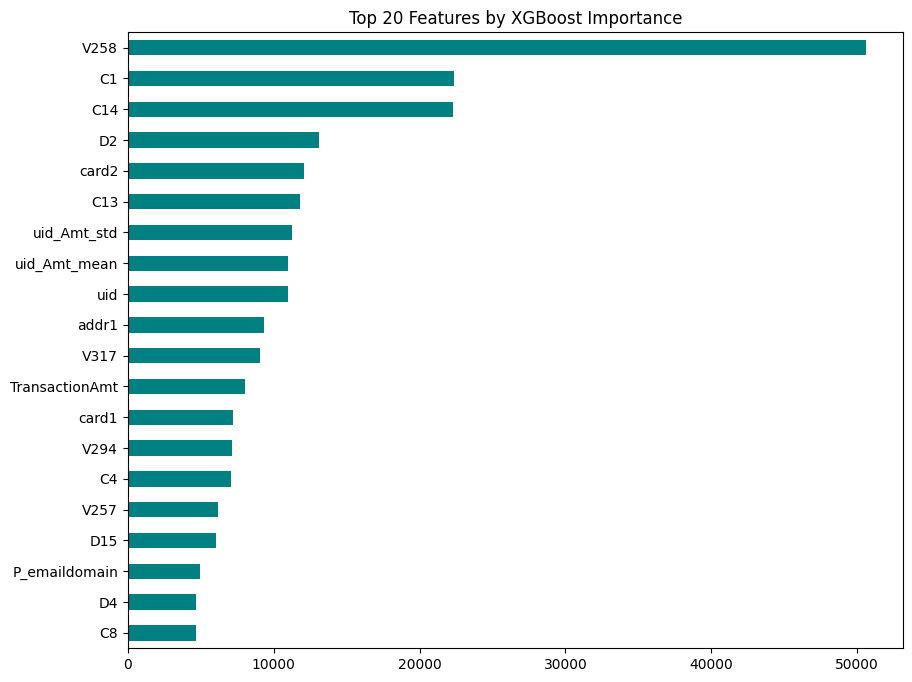

In [8]:
importances = pd.Series(clf.get_booster().get_score(importance_type='total_gain'))

# 2. Sort and Take Top 50
TOP_N = 100
best_features = importances.sort_values(ascending=False).head(TOP_N).index.tolist()

print(f"--- Top {TOP_N} Features Selected ---")
print(best_features[:10])  # Print top 10 to check

# 3. Visualize
plt.figure(figsize=(10, 8))
importances.sort_values(ascending=False).head(20).plot(kind='barh', color='teal')
plt.title('Top 20 Features by XGBoost Importance')
plt.gca().invert_yaxis() # Highest importance on top
plt.show()

In [9]:
FINAL_CAT_COLS = []
FINAL_NUM_COLS = []

print("classifying Top Features...")

for col in best_features:
    # A. Is it an Object (String) in the original cleaned data?
    if X_train_clean[col].dtype == 'object':
        FINAL_CAT_COLS.append(col)
        
    # B. Is it a Number but behaves like a Category? (Few unique values)
    # Example: 'card4' might be 1, 2, 3, 4. Treat as Category.
    elif X_train_clean[col].nunique() < 20:
        FINAL_CAT_COLS.append(col)
        
    # C. Otherwise, it is a Number (Amount, Time, Distance)
    else:
        FINAL_NUM_COLS.append(col)

print(f"--------------------------------")
print(f"Feature Split for Neural Network:")
print(f" - Categorical (Embeddings): {len(FINAL_CAT_COLS)}")
print(f" - Numerical (Scaled):       {len(FINAL_NUM_COLS)}")
print(f"--------------------------------")

manual_features = ['Amt_to_mean_ratio', 'hour', 'day_of_week']

for feat in manual_features:
    if feat not in best_features:
        best_features.append(feat)


if 'uid' in best_features:
    best_features.remove('uid')
    print("✅ Stĺpec 'uid' bol úspešne odstránený zo zoznamu čŕt.")
    
# Finalize the Datasets
# We now discard all other columns and keep only the winners
X_train_ready = X_train_clean[best_features].copy()
X_val_ready   = X_val_clean[best_features].copy()
X_test_ready  = X_test_clean[best_features].copy()

classifying Top Features...
--------------------------------
Feature Split for Neural Network:
 - Categorical (Embeddings): 30
 - Numerical (Scaled):       70
--------------------------------
✅ Stĺpec 'uid' bol úspešne odstránený zo zoznamu čŕt.


In [10]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

# 1. Separate your features based on the logic we established earlier
cat_cols = FINAL_CAT_COLS # Your 30 categorical features
num_cols = FINAL_NUM_COLS # Your 70 numerical features

cat_cols = [col for col in cat_cols if col in best_features]
print(f"Zostávajúce kategorické stĺpce: {cat_cols}")

# 2. Handle Numerical Scaling
# Transformers hate large numbers like TransactionAmt (e.g., 5000.0)
num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_num = scaler.fit_transform(num_imputer.fit_transform(X_train_ready[num_cols]))
X_val_num = scaler.transform(num_imputer.transform(X_val_ready[num_cols]))
X_test_num = scaler.transform(num_imputer.transform(X_test_ready[num_cols]))

# 3. Handle Categorical Encoding
# Each category needs a unique integer ID for the Embedding Layer
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')

# 2. Aplikuj imputer a okamžite premeň všetko na string (.astype(str))
# Toto vyrieši chybu ['float', 'str']
X_train_cat_imputed = cat_imputer.fit_transform(X_train_ready[cat_cols].astype(str))
X_val_cat_imputed = cat_imputer.transform(X_val_ready[cat_cols].astype(str))
X_test_cat_imputed = cat_imputer.transform(X_test_ready[cat_cols].astype(str))

# 3. Teraz už OrdinalEncoder prebehne bez problémov
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train_cat = encoder.fit_transform(X_train_cat_imputed)
X_val_cat = encoder.transform(X_val_cat_imputed)
X_test_cat = encoder.transform(X_test_cat_imputed)

print("✅ Kategorické dáta sú úspešne zakódované pre Transformer.")

# 4. Final Merge for the Model
X_train_transformer = np.hstack([X_train_num, X_train_cat])

Zostávajúce kategorické stĺpce: ['P_emaildomain', 'R_emaildomain', 'card6', 'V189', 'M5', 'V62', 'M4', 'V91', 'id_31', 'V70', 'ProductCD', 'DeviceInfo', 'M6', 'V12', 'V83', 'V54', 'day_of_week', 'V82', 'card4', 'DeviceType', 'V53', 'id_12', 'V61', 'V67', 'V66', 'V20', 'V76', 'V30', 'V13']
✅ Kategorické dáta sú úspešne zakódované pre Transformer.


In [11]:
# Zisti počet unikátnych hodnôt pre každý kategorický stĺpec
cat_cardinalities = [len(np.unique(X_train_cat[:, i])) for i in range(X_train_cat.shape[1])]

print(f"Kardinality (veľkosti slovníkov): {cat_cardinalities}")
# Napr. [4, 2, 50, ...] pre card4, card6, P_emaildomain atď.

Kardinality (veľkosti slovníkov): [60, 61, 5, 19, 3, 9, 4, 8, 109, 8, 5, 1547, 3, 5, 9, 8, 7, 9, 5, 3, 7, 3, 8, 10, 7, 16, 8, 9, 8]


In [12]:
import numpy as np

# Oprava kategorických indexov (Clipping)
# Toto zaistí, že žiadny index nebude mimo rozsah embedding tabuľky
for i in range(X_train_cat.shape[1]):
    max_val = cat_cardinalities[i] - 1
    X_train_cat[:, i] = np.clip(X_train_cat[:, i], 0, max_val)
    X_val_cat[:, i] = np.clip(X_val_cat[:, i], 0, max_val)

print("✅ Kategorické indexy boli ošetrené.")

✅ Kategorické indexy boli ošetrené.


In [ ]:
# import torch
# import torch.nn as nn

# class FTTransformer(nn.Module):
#     def __init__(self, num_numeric, cat_cardinalities, embed_dim=32, n_layers=3, n_heads=4):
#         super().__init__()
#         print(f"triggered init")
        
#         # 1. Feature Tokenizer pre numerické dáta (70 stĺpcov)
#         # Každé číslo dostane vlastný vektor veľkosti embed_dim
#         self.num_tokenizer = nn.ModuleList([
#             nn.Linear(1, embed_dim) for _ in range(num_numeric)
#         ])
        
#         # 2. Feature Tokenizer pre kategorické dáta (30 stĺpcov)
#         # Každá kategória (napr. card4) má vlastnú Embedding tabuľku
#         self.cat_embeddings = nn.ModuleList([
#             nn.Embedding(cardinality, embed_dim) for cardinality in cat_cardinalities
#         ])
        
#         # 3. Transformer Encoder (Srdce modelu)
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=embed_dim, nhead=n_heads, batch_first=True
#         )
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
#         # 4. Finálna klasifikácia (isFraud 0/1)
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear((num_numeric + len(cat_cardinalities)) * embed_dim, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x_num, x_cat):
#         # Tokenizácia numerických čŕt
#         num_tokens = [self.num_tokenizer[i](x_num[:, i].unsqueeze(-1)) for i in range(x_num.size(1))]
        
#         # Tokenizácia kategorických čŕt
#         cat_tokens = [self.cat_embeddings[i](x_cat[:, i].long()) for i in range(x_cat.size(1))]
        
#         # Spojenie všetkých čŕt do jednej "vety"
#         x = torch.stack(num_tokens + cat_tokens, dim=1) # Shape: [batch, 100, embed_dim]
        
#         # Prechod Transformerom (Self-Attention)
#         x = self.transformer(x)
        
#         return self.classifier(x)

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class NumericalTokenizer(nn.Module):
    """Transforms continuous features into embeddings."""
    def __init__(self, n_num_features, d_token):
        super().__init__()
        self.weights = nn.Parameter(torch.Tensor(n_num_features, d_token))
        self.biases = nn.Parameter(torch.Tensor(n_num_features, d_token))
        nn.init.xavier_uniform_(self.weights)
        nn.init.zeros_(self.biases)

    def forward(self, x):
        # x shape: [batch, n_num_features]
        # output shape: [batch, n_num_features, d_token]
        return x.unsqueeze(-1) * self.weights + self.biases

class AdvancedTabTransformer(nn.Module):
    def __init__(self, n_num_features, cat_cardinalities, d_token=128, n_heads=8, n_layers=6, dropout=0.2):
        super().__init__()
        
        # 1. Categorical Embeddings
        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(card, d_token) for card in cat_cardinalities
        ])
        
        # 2. Numerical Tokenizer
        self.num_tokenizer = NumericalTokenizer(n_num_features, d_token)
        
        # 3. [CLS] Token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_token))
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        
        # 4. Transformer Encoder Layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_token, 
            nhead=n_heads, 
            dim_feedforward=d_token * 4, 
            dropout=dropout, 
            activation='gelu',
            batch_first=True,
            norm_first=True  # Pre-Norm for better stability
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # 5. Final MLP Head
        self.mlp_head = nn.Sequential(
            nn.Linear(d_token, d_token // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_token // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x_num, x_cat):
        batch_size = x_num.size(0)
        
        # Tokenize Categories
        cat_tokens = [emb(x_cat[:, i]) for i, emb in enumerate(self.cat_embeddings)]
        cat_tokens = torch.stack(cat_tokens, dim=1) # [batch, n_cat, d_token]
        
        # Tokenize Numbers
        num_tokens = self.num_tokenizer(x_num) # [batch, n_num, d_token]
        
        # Add [CLS] Token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        
        # Concatenate all tokens: [CLS, Categories, Numbers]
        x = torch.cat([cls_tokens, cat_tokens, num_tokens], dim=1)
        
        # Pass through Transformer
        x = self.transformer(x)
        
        # Use only the [CLS] token output for classification
        cls_output = x[:, 0, :]
        
        return self.mlp_head(cls_output)


In [16]:
from torch.utils.data import DataLoader, TensorDataset

# 1. Konverzia dát na PyTorch Tensory
# Používame float32 pre čísla a long pre kategórie (indexy do embeddingov)
train_ds = TensorDataset(
    torch.tensor(X_train_num, dtype=torch.float32),
    torch.tensor(X_train_cat, dtype=torch.long),
    torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(-1)
)

val_ds = TensorDataset(
    torch.tensor(X_val_num, dtype=torch.float32),
    torch.tensor(X_val_cat, dtype=torch.long),
    torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(-1)
)

# 2. Vytvorenie DataLoaderov
# Batch size 1024 je dobrý kompromis pre rýchlosť a stabilitu
batch_size = 1024
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)

if torch.cuda.is_available():
    print(f"✅ GPU je dostupné: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("❌ GPU nie je dostupné. Model pobeží na CPU.")
    device = torch.device("cpu")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AdvancedTabTransformer(
    n_num_features=X_train_num.shape[1], 
    cat_cardinalities=cat_cardinalities,
    d_token=128, 
    n_heads=8, 
    n_layers=6
).to(device)

print(f"Model inicializovaný na zariadení: {device}")

✅ GPU je dostupné: NVIDIA GeForce RTX 4050 Laptop GPU
Model inicializovaný na zariadení: cuda


c:\Users\Matúš\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [19]:
import torch.optim as optim
from tqdm.auto import tqdm

# Nastavenie optimalizátora a straty
# optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() # Pretože model končí Sigmoidom
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

epochs = 15

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    
    # Pridanie tqdm progress baru
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
    
    for x_num, x_cat, y in pbar:
        x_num, x_cat, y = x_num.to(device), x_cat.to(device), y.to(device)
        
        optimizer.zero_grad()
        outputs = model(x_num, x_cat)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # Priebežná aktualizácia informácií v bare
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})
    
    avg_train_loss = train_loss / len(train_loader)
    
    # Validácia (bez baru, alebo môžeš pridať druhý)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_num, x_cat, y in val_loader:
            x_num, x_cat, y = x_num.to(device), x_cat.to(device), y.to(device)
            outputs = model(x_num, x_cat)
            val_loss += criterion(outputs, y).item()
    
    avg_val_loss = val_loss / len(val_loader)
    scheduler.step(avg_val_loss)
    
    print(f"📊 Summary Epoch {epoch}: Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")



# def train_one_epoch(epoch_num):
#     model.train()
#     total_loss = 0
#     # Add tqdm here to see progress!
#     pbar = tqdm(train_loader, desc=f"Epoch {epoch_num}") 
    
#     for x_num, x_cat, y in pbar:
#         x_num, x_cat, y = x_num.to(device), x_cat.to(device), y.to(device)
        
#         optimizer.zero_grad()
#         output = model(x_num, x_cat)
#         loss = criterion(output, y)
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()
#         # Update the bar with the current loss
#         pbar.set_postfix({'loss': f"{loss.item():.4f}"}) 
        
#     return total_loss / len(train_loader)

# # Spustenie trénovania (skús na začiatok 10 epoch)
# for epoch in range(1, 11):
#     avg_loss = train_one_epoch(epoch)
#     print(f"✅ Finished Epoch {epoch}: Average Loss = {avg_loss:.4f}")
    
#     # ZÁCHRANA: Uložíme model po každej epoche
#     checkpoint_name = f'transformer_epoch_{epoch}.pth'
#     torch.save(model.state_dict(), checkpoint_name)
#     print(f"✅ Checkpoint uložený ako: {checkpoint_name}")

Epoch 1/15:   0%|          | 0/404 [00:00<?, ?it/s]

📊 Summary Epoch 1: Train Loss: 0.1197 | Val Loss: 0.1118 | LR: 0.000100


Epoch 2/15:   0%|          | 0/404 [00:00<?, ?it/s]

📊 Summary Epoch 2: Train Loss: 0.1041 | Val Loss: 0.1058 | LR: 0.000100


Epoch 3/15:   0%|          | 0/404 [00:00<?, ?it/s]

📊 Summary Epoch 3: Train Loss: 0.0993 | Val Loss: 0.1090 | LR: 0.000100


Epoch 4/15:   0%|          | 0/404 [00:00<?, ?it/s]

📊 Summary Epoch 4: Train Loss: 0.0959 | Val Loss: 0.1061 | LR: 0.000100


Epoch 5/15:   0%|          | 0/404 [00:00<?, ?it/s]

📊 Summary Epoch 5: Train Loss: 0.0923 | Val Loss: 0.1053 | LR: 0.000100


Epoch 6/15:   0%|          | 0/404 [00:00<?, ?it/s]

📊 Summary Epoch 6: Train Loss: 0.0891 | Val Loss: 0.1026 | LR: 0.000100


Epoch 7/15:   0%|          | 0/404 [00:00<?, ?it/s]

📊 Summary Epoch 7: Train Loss: 0.0865 | Val Loss: 0.0999 | LR: 0.000100


Epoch 8/15:   0%|          | 0/404 [00:00<?, ?it/s]

📊 Summary Epoch 8: Train Loss: 0.0843 | Val Loss: 0.1119 | LR: 0.000100


Epoch 9/15:   0%|          | 0/404 [00:00<?, ?it/s]

📊 Summary Epoch 9: Train Loss: 0.0827 | Val Loss: 0.1094 | LR: 0.000100


Epoch 10/15:   0%|          | 0/404 [00:00<?, ?it/s]

📊 Summary Epoch 10: Train Loss: 0.0815 | Val Loss: 0.1043 | LR: 0.000050


Epoch 11/15:   0%|          | 0/404 [00:00<?, ?it/s]

📊 Summary Epoch 11: Train Loss: 0.0775 | Val Loss: 0.1088 | LR: 0.000050


Epoch 12/15:   0%|          | 0/404 [00:00<?, ?it/s]

📊 Summary Epoch 12: Train Loss: 0.0766 | Val Loss: 0.1154 | LR: 0.000050


Epoch 13/15:   0%|          | 0/404 [00:00<?, ?it/s]

📊 Summary Epoch 13: Train Loss: 0.0755 | Val Loss: 0.1127 | LR: 0.000025


Epoch 14/15:   0%|          | 0/404 [00:00<?, ?it/s]

📊 Summary Epoch 14: Train Loss: 0.0734 | Val Loss: 0.1252 | LR: 0.000025


Epoch 15/15:   0%|          | 0/404 [00:00<?, ?it/s]

📊 Summary Epoch 15: Train Loss: 0.0726 | Val Loss: 0.1262 | LR: 0.000025


In [20]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import torch

# 1. Prepneme model do režimu evaluácie
model.eval()

y_probs = []
y_true_list = []

print("Evaluating Advanced Transformer...")

# 2. Získanie predpovedí (vypnuté gradienty šetria VRAM na RTX 4050)
with torch.no_grad():
    for x_num, x_cat, y in val_loader:
        # Presun dát na GPU
        x_num, x_cat = x_num.to(device), x_cat.to(device)
        
        # Model vráti pravdepodobnosť (vďaka Sigmoidu na konci AdvancedTabTransformer)
        outputs = model(x_num, x_cat)
        
        # Ukladáme výsledky (musíme ich poslať na CPU a previesť na numpy)
        y_probs.extend(outputs.cpu().numpy())
        y_true_list.extend(y.numpy())

# Prevod na ploché numpy polia
y_probs = np.array(y_probs).flatten()
y_true_list = np.array(y_true_list).flatten()

# 3. Výpočet finálneho skóre
advanced_auc = roc_auc_score(y_true_list, y_probs)

print(f"\n" + "="*30)
print(f"🔥 ADVANCED TRANSFORMER ROC-AUC: {advanced_auc:.4f}")
print(f"="*30)

Evaluating Advanced Transformer...

🔥 ADVANCED TRANSFORMER ROC-AUC: 0.8587


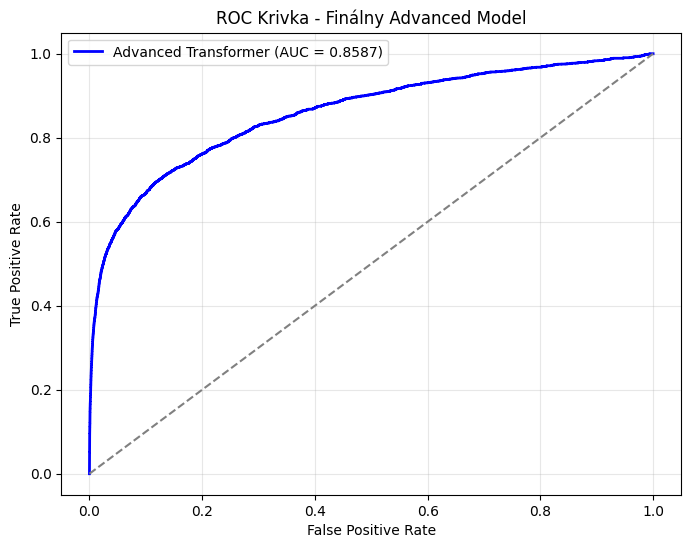

In [21]:
# 4. Vizualizácia (pre tvoj Word dokument)
fpr, tpr, _ = roc_curve(y_true_list, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Advanced Transformer (AUC = {advanced_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Krivka - Finálny Advanced Model')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [19]:
import torch
import numpy as np

# 1. Získaj maximálne povolené indexy pre každý stĺpec z tvojich kardinalít
# (Odčítame 1, pretože indexujeme od nuly)
max_indices = [c - 1 for c in cat_cardinalities]

# 2. "Ostrihaj" testovacie dáta (všetko nad limit zmeň na 0 alebo max index)
X_val_cat_safe = X_val_cat.copy()
for i in range(X_val_cat_safe.shape[1]):
    # Všetky hodnoty vyššie ako trénované maximum nastavíme na 0 (neznáma kategória)
    X_val_cat_safe[X_val_cat_safe[:, i] > max_indices[i], i] = 0

# 3. Vytvor nový loader so "bezpečnými" dátami
val_ds_safe = TensorDataset(
    torch.tensor(X_val_num, dtype=torch.float32),
    torch.tensor(X_val_cat_safe, dtype=torch.long),
    torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(-1)
)
val_loader_safe = DataLoader(val_ds_safe, batch_size=256) # Menší batch pre RTX 4050

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import torch

# 1. Prepneme model do režimu evaluácie
model.eval()

y_probs = []
y_true = []

# 2. Získanie predpovedí bez výpočtu gradientov (šetrí VRAM)
with torch.no_grad():
    for x_num, x_cat, y in val_loader:
        # Presun na GPU
        x_num, x_cat = x_num.to(device), x_cat.to(device)
        
        # Získanie pravdepodobnosti (výstup Transformera)
        outputs = model(x_num, x_cat)
        
        # Uloženie (presun späť na CPU pre sklearn)
        y_probs.extend(outputs.cpu().numpy())
        y_true.extend(y.numpy())

# Prevod na numpy polia
y_probs = np.array(y_probs).flatten()
y_true = np.array(y_true).flatten()

# 3. Výpočet skóre
transformer_auc = roc_auc_score(y_true, y_probs)

print(f"========================================")
print(f"🚀 TRANSFORMER ROC-AUC: {transformer_auc:.4f}")
print(f"========================================")

🚀 TRANSFORMER ROC-AUC: 0.8591


================================================
================================================
COMBINED WITH XGBOOST                 -       data su rozdielne, nie su v spravnom poradi
================================================
================================================

In [19]:
# 1. Setup the 3 datasets (Fresh copies)
# We use the 'ready' sets (Top 50 features) you created earlier
X_xgb_train = X_train_ready.copy()
X_xgb_val   = X_val_ready.copy()
X_xgb_test  = X_test_ready.copy()

FINAL_CAT_COLS = [col for col in FINAL_CAT_COLS if col in best_features]
print(f"Zostávajúce kategorické stĺpce: {FINAL_CAT_COLS}")

print("Preparing data for XGBoost...")

# 2. Encode Categoricals (Text -> Number)
# XGBoost can't read "Visa", so we turn it into numbers.
# We do NOT need to scale numbers or fill missing values.
for col in FINAL_CAT_COLS:
    # Combine to ensure same encoding across all sets
    temp_all = pd.concat([X_xgb_train[col], X_xgb_val[col], X_xgb_test[col]])
    
    # Fit the encoder
    le = LabelEncoder()
    le.fit(temp_all.astype(str))
    
    # Transform each set
    X_xgb_train[col] = le.transform(X_xgb_train[col].astype(str))
    X_xgb_val[col]   = le.transform(X_xgb_val[col].astype(str))
    X_xgb_test[col]  = le.transform(X_xgb_test[col].astype(str))

print("✅ Data Ready. (Notice: No scaling or mean-filling needed!)")

Zostávajúce kategorické stĺpce: ['P_emaildomain', 'R_emaildomain', 'card6', 'V189', 'M5', 'V62', 'M4', 'V91', 'id_31', 'V70', 'ProductCD', 'DeviceInfo', 'M6', 'V12', 'V83', 'V54', 'day_of_week', 'V82', 'card4', 'DeviceType', 'V53', 'id_12', 'V61', 'V67', 'V66', 'V20', 'V76', 'V30', 'V13']
Preparing data for XGBoost...
✅ Data Ready. (Notice: No scaling or mean-filling needed!)


In [20]:
# 1. Calculate Class Weight (For Imbalance)
# XGBoost uses 'scale_pos_weight' = count(neg) / count(pos)
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
print(f"Fraud Imbalance Ratio: {ratio:.2f}")

# 2. Build the Model
clf = XGBClassifier(
    n_estimators=2000,        # Max epochs (high, because we stop early)
    learning_rate=0.02,       # Slow & careful learning
    max_depth=6,             # Deep trees for complex fraud patterns
    subsample=0.8,            # Use 80% of rows per tree
    colsample_bytree=0.8,     # Use 80% of columns per tree
    scale_pos_weight=ratio,   # Handle the imbalance
    missing=np.nan,           # Handle missing values automatically
    eval_metric='auc',        # Optimize for AUC
    tree_method='hist',       # Fast mode
    n_jobs=-1,
    random_state=42,
    reg_alpha=10,
    reg_lambda=10,
    min_child_weight=10,
    early_stopping_rounds=50 # Stop if validation score doesn't improve for 50 rounds
)

# 3. Train with Early Stopping
print("\nStarting XGBoost Training...")
clf.fit(
    X_xgb_train, y_train,
    # This is the "Validation" step
    eval_set=[(X_xgb_train, y_train), (X_xgb_val, y_val)],
    verbose=50                # Print progress every 50 rounds
)

Fraud Imbalance Ratio: 27.43

Starting XGBoost Training...
[0]	validation_0-auc:0.85388	validation_1-auc:0.82178
[50]	validation_0-auc:0.88735	validation_1-auc:0.86483
[100]	validation_0-auc:0.89801	validation_1-auc:0.87469
[150]	validation_0-auc:0.90699	validation_1-auc:0.88317
[200]	validation_0-auc:0.91429	validation_1-auc:0.88887
[250]	validation_0-auc:0.92265	validation_1-auc:0.89445
[300]	validation_0-auc:0.92986	validation_1-auc:0.89928
[350]	validation_0-auc:0.93545	validation_1-auc:0.90282
[400]	validation_0-auc:0.94029	validation_1-auc:0.90555
[450]	validation_0-auc:0.94433	validation_1-auc:0.90756
[500]	validation_0-auc:0.94764	validation_1-auc:0.90881
[550]	validation_0-auc:0.95096	validation_1-auc:0.91053
[600]	validation_0-auc:0.95368	validation_1-auc:0.91117
[650]	validation_0-auc:0.95622	validation_1-auc:0.91187
[700]	validation_0-auc:0.95867	validation_1-auc:0.91285
[750]	validation_0-auc:0.96107	validation_1-auc:0.91379
[800]	validation_0-auc:0.96342	validation_1-auc:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=2000,
              n_jobs=-1, num_parallel_tree=None, ...)

In [21]:
from sklearn.metrics import roc_auc_score

print("------------------------------------------------")
print("Evaluating XGBoost on TEST Set...")

# 1. Predict (Probabilities)
xgb_preds = clf.predict_proba(X_xgb_test)[:, 1]

# 2. Score
xgb_auc = roc_auc_score(y_test, xgb_preds)

print(f"🏆 XGBoost FINAL TEST ROC-AUC: {xgb_auc:.5f}")
print("------------------------------------------------")

------------------------------------------------
Evaluating XGBoost on TEST Set...
🏆 XGBoost FINAL TEST ROC-AUC: 0.90456
------------------------------------------------


In [26]:
# DÔLEŽITÉ: shuffle MUSÍ byť False
val_loader_fixed = DataLoader(val_ds, batch_size=256, shuffle=False)

In [27]:
model.eval()
transformer_probs_fixed = []
y_true_fixed = []

with torch.no_grad():
    for x_num, x_cat, y in val_loader_fixed:
        x_num, x_cat = x_num.to(device), x_cat.to(device)
        outputs = model(x_num, x_cat)
        transformer_probs_fixed.extend(outputs.cpu().numpy())
        y_true_fixed.extend(y.numpy())

transformer_probs_fixed = np.array(transformer_probs_fixed).flatten()
y_true_fixed = np.array(y_true_fixed).flatten()

In [28]:
# Teraz už vieme, že y_true_fixed a xgb_preds idú v rovnakom poradí
ensemble_probs = (0.7 * xgb_preds) + (0.3 * transformer_probs_fixed)

print(f"Opravený ENSEMBLE ROC-AUC: {roc_auc_score(y_true_fixed, ensemble_probs):.4f}")

Opravený ENSEMBLE ROC-AUC: 0.6730


In [25]:
# 1. Výpočet váženého priemeru (Ensemble)
# Používame xgb_preds a y_probs (Transformer)
ensemble_probs = (0.7 * xgb_preds) + (0.3 * y_probs)

# 2. Výpočet ROC-AUC skóre pre všetky tri prístupy
auc_xgb = roc_auc_score(y_test, xgb_preds)
auc_transformer = roc_auc_score(y_true, y_probs)
auc_ensemble = roc_auc_score(y_true, ensemble_probs)

print(f"--- Výsledky ---")
print(f"XGBoost ROC-AUC:     {auc_xgb:.4f}")
print(f"Transformer ROC-AUC: {auc_transformer:.4f}")
print(f"----------------")
print(f"🚀 ENSEMBLE ROC-AUC:  {auc_ensemble:.4f}")

--- Výsledky ---
XGBoost ROC-AUC:     0.9046
Transformer ROC-AUC: 0.8591
----------------
🚀 ENSEMBLE ROC-AUC:  0.6730
